## Assignment objective

This assignment is to feedback on your learning in deep learning theory and its application to  data analytics or artificial intelligence problems.  

It builds on Assignment 1 but requires a higher level of mastery of deep learning theory and programming/engineering skills. In particular, you will experience training a much deeper network on a large-scale dataset. You will encounter  practical issues that help you consolidate textbook learning. 

## Task 1 Solving Fashion-MNIST with Convolutional Neural Networks

*(weight ~20%)*

In Assignment 1, you tackled the image classification problem in Fashion-MNIST. There, you used a Densely Connected Neural Network. You should now know that is not an optimal model architecture for the problem. In Assignment 2, you will apply the best practices of deep-learning computer vision to improve the image classification performance.

####Setting up

In [ ]:
%tensorflow_version 2.x
# TensorFlow and tf.keras
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import initializers
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.regularizers import l1, l2

# Helper libraries
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [ ]:
#testing
def model_1b():
  model = models.Sequential()
  model.add(layers.Conv2D(100, (3, 3), padding = 'valid', strides = 2, 
                          input_shape=(200, 300, 3)))

  model.add(layers.Conv2D(200, (3, 3), padding = 'valid', strides = 2))
  
  model.add(layers.Conv2D(400, (3, 3), padding = 'valid', strides = 2))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

baseline_model = model_1b()
baseline_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 99, 149, 100)      2800      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 49, 74, 200)       180200    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 36, 400)       720400    
Total params: 903,400
Trainable params: 903,400
Non-trainable params: 0
_________________________________________________________________


### Task 1.1 Revisit Fashion-MNIST classification with DNN

*(weight ~3%)*

Review your Assignment 1 solution, and reproduce the experiment here. Try to improve the model without changing the model architecture.


####Load dataset and construce pipelines

In [ ]:
#load the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()

#split train, validation sets
x, y = train
x_test, y_test = test

#process train sets
x = x.reshape(60000, 28 * 28).astype('float32')/255
y = to_categorical(y)

#process test set
x_test = x_test.reshape(10000, 28 * 28).astype('float32')/255
y_test = to_categorical(y_test)

#split train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

print("x_train.shape:", x_train.shape, ", y_train.shape:", y_train.shape)
print("x_valid.shape:", x_valid.shape, ", y_valid.shape:", y_valid.shape)
print("x_test.shape:", x_test.shape, ", y_test.shape:", y_test.shape)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
valid_batches = valid_set.batch(batch_size)
test_batches = test_set.batch(batch_size)

x_train.shape: (48000, 784) , y_train.shape: (48000, 10)
x_valid.shape: (12000, 784) , y_valid.shape: (12000, 10)
x_test.shape: (10000, 784) , y_test.shape: (10000, 10)


####An experiment with decay rate

In this part, I will reconstruct the model that I built in Assignment 1. In order to improve the the model without changing the architecture, I will run an experiment with the time-based learning rate decay that is a built-in option inside optimizer SGD. Last time, I used decay = 2e-6. This time, I will try out 2 scenarios one with decay = 1e-3 and one with decay = 2e-6 to compare the outcomes and determine which decay rate better promotes model training. I still keep the same momentum = 0.9 and learning rate = 0.01 as I used in assignment 1.

In [ ]:
# reconstruct model from Assignment 1 and run experiment:
def a1_model(para):
  model = models.Sequential()
  model.add(layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=0), input_shape = (28*28,)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(64, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(10, activation='softmax'))

  optimizer = keras.optimizers.SGD(lr=para[0], momentum=para[1], decay=para[2], nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

lrs = [0.01]
momentums = [0.9]
decays = [1e-3, 2e-6]
combi = [[a,b,c] for a in lrs for b in momentums for c in decays]

test_results = []
histories = []
for x in combi:
  model = a1_model(x)
  history = model.fit(
      train_batches,
      epochs=100,
      validation_data=valid_batches,
      verbose = 0)
  test_loss, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Learning rate: {}, Momentum: {}, Decay: {}, test accuracy: {}'.format(x[0], x[1], x[2], test_acc))
  test_results.append(test_acc)
  histories.append(history)

Learning rate: 0.01, Momentum: 0.9, Decay: 0.001, test accuracy: 0.8824999928474426
Learning rate: 0.01, Momentum: 0.9, Decay: 2e-06, test accuracy: 0.8921999931335449


Higher test accuracy with Decay: 2e-06, test accuracy: 0.8921999931335449
Lower test accuracy with Decay: 0.001, test accuracy: 0.8824999928474426


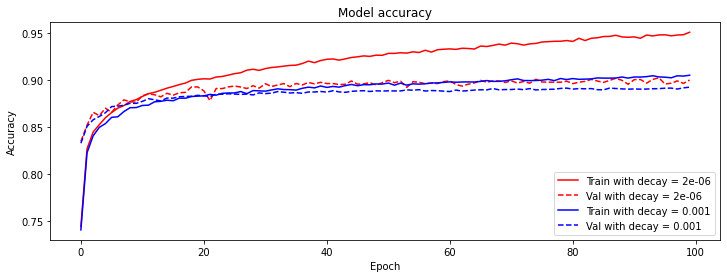

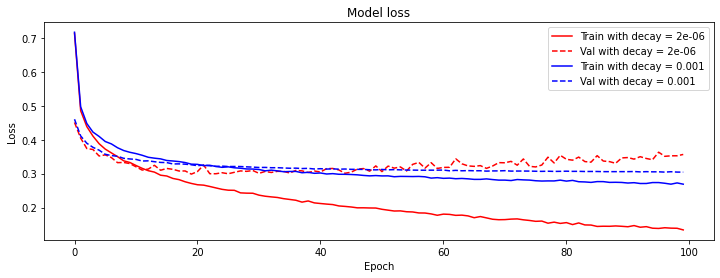

In [ ]:
# Parameter values at which test accuracy is higher
better_acc = np.argmax(test_results)
better_combi = combi[better_acc]
worse_acc = np.argmin(test_results)
worse_combi = combi[worse_acc]

print("Higher test accuracy with Decay: {}, test accuracy: {}".format(better_combi[2], test_results[better_acc]))
print("Lower test accuracy with Decay: {}, test accuracy: {}".format(worse_combi[2], test_results[worse_acc]))

history1 = histories[better_acc]
history0 = histories[worse_acc]

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(history1.history['categorical_accuracy'],'r', label = 'Train with decay = {}'.format(better_combi[2]))
plt.plot(history1.history['val_categorical_accuracy'],'r--', label = 'Val with decay = {}'.format(better_combi[2]))
plt.plot(history0.history['categorical_accuracy'],'b', label = 'Train with decay = {}'.format(worse_combi[2]))
plt.plot(history0.history['val_categorical_accuracy'],'b--', label = 'Val with decay = {}'.format(worse_combi[2]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(history1.history['loss'], 'r', label = 'Train with decay = {}'.format(better_combi[2]))
plt.plot(history1.history['val_loss'], 'r--', label = 'Val with decay = {}'.format(better_combi[2]))
plt.plot(history0.history['loss'], 'b', label = 'Train with decay = {}'.format(worse_combi[2]))
plt.plot(history0.history['val_loss'], 'b--', label = 'Val with decay = {}'.format(worse_combi[2]))
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the results, we can see the test accuracy of model with decay = 2e-6 is 1% better than that with decay = 1e-3 (89.2% compared with 88.2%). However, model with decay = 2e-6 gets overfitted training after 20 epochs. In terms of generalization, the latter model with decay = 1e-3 turns out to be more robust. In the next section, I will use time-based learning decay = 1e-3 inside SGD optimiser to compile model.

### Task 1.2 Train a ConvNet from scratch

*(weight ~5%)*

Build a ConvNet to replace the densely connected network in Task 1.1. Report the classification accuracy on the test set. Aim to achieve higher accuracy. 



####Reload dataset, preprocess and construct pipelines

Since in ConvNet, we do not need to flatten input data before training, I only reshape the images into 3 dimension with the last dimension being the number of image channel. Fashion-MNIST images are grayscale images therefore the number of channel is 1. After that, I convert the data type into 'float32' then normalize the images by dividing input data with 255.

In [ ]:
#reload the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()

#split train, validation sets
x, y = train
x_test, y_test = test

#process train and validation sets
x = x.reshape(60000, 28, 28, 1).astype('float32')/255
y = to_categorical(y)

#process test set
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32')/255
y_test = to_categorical(y_test)

#split train and validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

print("x_train.shape:", x_train.shape, ", y_train.shape:", y_train.shape)
print("x_valid.shape:", x_valid.shape, ", y_valid.shape:", y_valid.shape)
print("x_test.shape:", x_test.shape, ", y_test.shape:", y_test.shape)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

#batch the sets according to batch_size
batch_size = 64
train_batches = train_set.shuffle(buffer_size=1024).batch(batch_size)
valid_batches = valid_set.batch(batch_size)
test_batches = test_set.batch(batch_size)

x_train.shape: (48000, 28, 28, 1) , y_train.shape: (48000, 10)
x_valid.shape: (12000, 28, 28, 1) , y_valid.shape: (12000, 10)
x_test.shape: (10000, 28, 28, 1) , y_test.shape: (10000, 10)


####ConvNet Baseline model construction

In this section, I will do experiments with models of 1-2-3 convolutional blocks respectively. In each type, I tried out different number of filters in each block, then compare test accuracy produced by these models to determine the best number of blocks and the number of filters for each layer to construct the Conv Baseline model.

#####Models with 1 conv block

In [ ]:
def model_1b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[1], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden = [32, 64, 128]
dense = [256, 512, 1024]
para_1b = [[a,b] for a in hidden for b in dense]

results_1b = []
histories_1b = []
for x in para_1b:
  model = model_1b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}, dense: {}, test accuracy: {}'.format(x[0], x[1], test_acc))
  results_1b.append(test_acc)
  histories_1b.append(history)

  # Para at which test acc is highest
best_acc_1b = np.argmax(results_1b)
best_para_1b = para_1b[best_acc_1b]
print("Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_1b[0],best_para_1b[1], results_1b[best_acc_1b]))

Conv2D: 32, dense: 256, test accuracy: 0.9067000150680542
Conv2D: 32, dense: 512, test accuracy: 0.9100000262260437
Conv2D: 32, dense: 1024, test accuracy: 0.9118000268936157
Conv2D: 64, dense: 256, test accuracy: 0.9118000268936157
Conv2D: 64, dense: 512, test accuracy: 0.9140999913215637
Conv2D: 64, dense: 1024, test accuracy: 0.9142000079154968
Conv2D: 128, dense: 256, test accuracy: 0.9104999899864197
Conv2D: 128, dense: 512, test accuracy: 0.9107999801635742
Conv2D: 128, dense: 1024, test accuracy: 0.9144999980926514
Best model with 1 block: Conv2D 128, dense: 1024, Test accuracy for 20 epochs: 0.9144999980926514


Experiments show that model with 1 Convolutional block of 128 filters and 1 Dense layer of 1024 nodes produces the highest test accuracy 91.49% among models with 1 block. I train this model for 200 epochs, test accuracy of model after 200 epochs training is 92.07%

In [ ]:
# Reload and run the best model for 200 epochs
best_model_1b = model_1b(best_para_1b)
best_history_1b = best_model_1b.fit(train_batches, epochs=200, validation_data=valid_batches)
_, best_test_acc_1b = best_model_1b.evaluate(test_batches, verbose = 0)
print('Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_1b[0], best_para_1b[1], best_test_acc_1b))

Epoch 1/200
750/750 [==============================] - 6s 7ms/step - loss: 0.4696 - categorical_accuracy: 0.8431 - val_loss: 0.3237 - val_categorical_accuracy: 0.8901
Epoch 2/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2945 - categorical_accuracy: 0.8949 - val_loss: 0.2884 - val_categorical_accuracy: 0.8982
Epoch 3/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2539 - categorical_accuracy: 0.9091 - val_loss: 0.2712 - val_categorical_accuracy: 0.9060
Epoch 4/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2298 - categorical_accuracy: 0.9175 - val_loss: 0.2544 - val_categorical_accuracy: 0.9118
Epoch 5/200
750/750 [==============================] - 5s 7ms/step - loss: 0.2118 - categorical_accuracy: 0.9239 - val_loss: 0.2507 - val_categorical_accuracy: 0.9129
Epoch 6/200
750/750 [==============================] - 5s 7ms/step - loss: 0.1970 - categorical_accuracy: 0.9297 - val_loss: 0.2412 - val_categorical_accuracy: 0.914

#####Models with 2 conv blocks

In [ ]:
def model_2b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[2], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden1 = [32, 64]
hidden2 = [128, 256]
dense = [512, 1024]
para_2b = [[a,b,c] for a in hidden1 for b in hidden2 for c in dense]

results_2b = []
histories_2b = []
for x in para_2b:
  model = model_2b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}, dense: {}, test accuracy: {}'.format(x[0], x[1], x[2], test_acc))
  results_2b.append(test_acc)
  histories_2b.append(history)

  # Para at which test acc is highest
best_acc_2b = np.argmax(results_2b)
best_para_2b = para_2b[best_acc_2b]
print("Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_2b[0],best_para_2b[1],best_para_2b[2], results_2b[best_acc_2b]))

Conv2D: 32-128, dense: 512, test accuracy: 0.904699981212616
Conv2D: 32-128, dense: 1024, test accuracy: 0.9061999917030334
Conv2D: 32-256, dense: 512, test accuracy: 0.909500002861023
Conv2D: 32-256, dense: 1024, test accuracy: 0.9071000218391418
Conv2D: 64-128, dense: 512, test accuracy: 0.9099000096321106
Conv2D: 64-128, dense: 1024, test accuracy: 0.9075000286102295
Conv2D: 64-256, dense: 512, test accuracy: 0.9110000133514404
Conv2D: 64-256, dense: 1024, test accuracy: 0.9132999777793884
Best model with 2 blocks: Conv2D 64-256, dense: 1024, Test accuracy for 20 epochs: 0.9132999777793884


Experiments show that model with 2 Convolutional blocks of 64 and 256 filters respectively and 1 Dense layer of 1024 nodes produces the highest test accuracy 91.33% among models with 2 blocks. I train this model for 200 epochs, test accuracy after 200 epochs is 91.38%.

In [ ]:
# Reload and run the best model for 200 epochs
best_model_2b = model_2b(best_para_2b)
best_history_2b = best_model_2b.fit(train_batches, epochs=200, validation_data=valid_batches)
_, best_test_acc_2b = best_model_2b.evaluate(test_batches, verbose = 0)
print('Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_2b[0], best_para_2b[1], best_para_2b[2], best_test_acc_2b))

Epoch 1/200
750/750 [==============================] - 5s 6ms/step - loss: 0.4613 - categorical_accuracy: 0.8375 - val_loss: 0.3419 - val_categorical_accuracy: 0.8776
Epoch 2/200
750/750 [==============================] - 5s 6ms/step - loss: 0.3094 - categorical_accuracy: 0.8894 - val_loss: 0.3007 - val_categorical_accuracy: 0.8920
Epoch 3/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2682 - categorical_accuracy: 0.9038 - val_loss: 0.2794 - val_categorical_accuracy: 0.9000
Epoch 4/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2414 - categorical_accuracy: 0.9127 - val_loss: 0.2644 - val_categorical_accuracy: 0.9069
Epoch 5/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2231 - categorical_accuracy: 0.9196 - val_loss: 0.2640 - val_categorical_accuracy: 0.9062
Epoch 6/200
750/750 [==============================] - 5s 6ms/step - loss: 0.2092 - categorical_accuracy: 0.9247 - val_loss: 0.2644 - val_categorical_accuracy: 0.907

#####Models with 3 conv blocks

In [ ]:
def model_3b(para):
  model = models.Sequential()
  model.add(layers.Conv2D(para[0], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[1], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Conv2D(para[2], (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(para[3], activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
hidden1 = [32, 64]
hidden2 = [64, 128]
hidden3 = [128, 256]
dense = [512, 1024]
para_3b = [[a,b,c,d] for a in hidden1 for b in hidden2 for c in hidden3 for d in dense]

results_3b = []
histories_3b = []
for x in para_3b:
  model = model_3b(x)
  history = model.fit(
      train_batches,
      epochs=20,
      validation_data=valid_batches,
      verbose = 0)
  _, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Conv2D: {}-{}-{}, dense: {}, test accuracy: {}'.format(x[0], x[1], x[2], x[3], test_acc))
  results_3b.append(test_acc)
  histories_3b.append(history)

  # Para at which test acc is highest
best_acc_3b = np.argmax(results_3b)
best_para_3b = para_3b[best_acc_3b]
print("Best model with 3 blocks: Conv2D {}-{}-{}, dense: {}, Test accuracy for 20 epochs: {}".format(best_para_3b[0],best_para_3b[1],best_para_3b[2],best_para_3b[3], results_3b[best_acc_3b]))

Conv2D: 32-64-128, dense: 512, test accuracy: 0.8823999762535095
Conv2D: 32-64-128, dense: 1024, test accuracy: 0.8844000101089478
Conv2D: 32-64-256, dense: 512, test accuracy: 0.8845999836921692
Conv2D: 32-64-256, dense: 1024, test accuracy: 0.8844000101089478
Conv2D: 32-128-128, dense: 512, test accuracy: 0.8912000060081482
Conv2D: 32-128-128, dense: 1024, test accuracy: 0.8844000101089478
Conv2D: 32-128-256, dense: 512, test accuracy: 0.8853999972343445
Conv2D: 32-128-256, dense: 1024, test accuracy: 0.8888000249862671
Conv2D: 64-64-128, dense: 512, test accuracy: 0.8873999714851379
Conv2D: 64-64-128, dense: 1024, test accuracy: 0.8805999755859375
Conv2D: 64-64-256, dense: 512, test accuracy: 0.8889999985694885
Conv2D: 64-64-256, dense: 1024, test accuracy: 0.887499988079071
Conv2D: 64-128-128, dense: 512, test accuracy: 0.8924999833106995
Conv2D: 64-128-128, dense: 1024, test accuracy: 0.890500009059906
Conv2D: 64-128-256, dense: 512, test accuracy: 0.8902000188827515
Conv2D: 64-12

Apparently, models with 3 Convolutional blocks train data the worst compared to those with 1 and 2 blocks. Hence, I will not run the best model with 3 blocks for more epochs. Next section, I will only compare training performance between best models with 1 and 2 blocks.

#####Comparison

Below are plots and test accuracy of the best models with 1 and 2 blocks respectively:

Best model with 1 blocks: Conv2D 128, dense: 1024, Test accuracy for 200 epochs: 0.9207000136375427
Best model with 2 blocks: Conv2D 64-256, dense: 1024, Test accuracy for 200 epochs: 0.9138000011444092


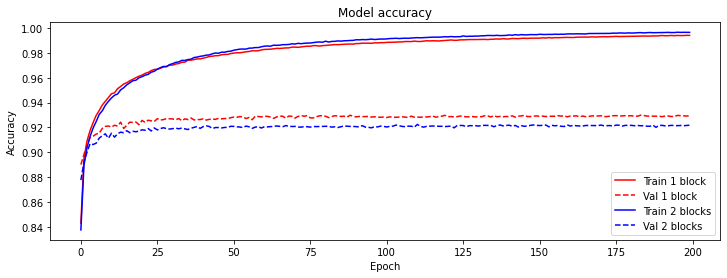

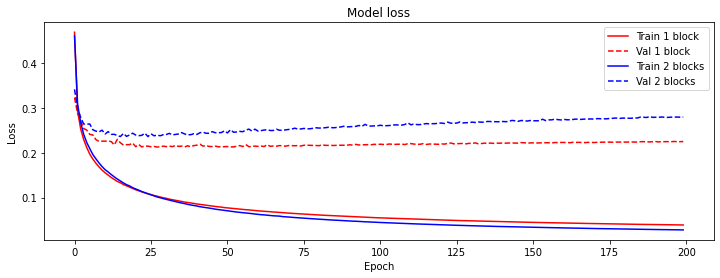

In [ ]:
# Test accuracy
print('Best model with 1 block: Conv2D {}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_1b[0],best_para_1b[1], best_test_acc_1b))
print('Best model with 2 blocks: Conv2D {}-{}, dense: {}, Test accuracy for 200 epochs: {}'.format(best_para_2b[0], best_para_2b[1], best_para_2b[2], best_test_acc_2b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'r', label = 'Train 1 block')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'r--', label = 'Val 1 block')
plt.plot(best_history_2b.history['categorical_accuracy'],'b', label = 'Train 2 blocks')
plt.plot(best_history_2b.history['val_categorical_accuracy'],'b--', label = 'Val 2 blocks')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'r', label = 'Train 1 block')
plt.plot(best_history_1b.history['val_loss'], 'r--', label = 'Val 1 block')
plt.plot(best_history_2b.history['loss'], 'b', label = 'Train 2 blocks')
plt.plot(best_history_2b.history['val_loss'], 'b--', label = 'Val 2 blocks')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the training result after 200 epochs, the best model with 1 block turns out to have better training performance on the dataset in terms of both optimization capacity (lower loss) and generalization (less overfit). Therefore, in the next parts, I will use model with 1 block having 1 Conv2D layer of 128 nodes and 1 Dense layer of 1024 nodes as baseline model for upcoming comparisons. 





#####ConvNet Baseline model architecture

This is how our Baseline Convnet model architecture will look like:

In [ ]:
#testing
def model_1b():
  model = models.Sequential()
  model.add(layers.Input(shape=(200, 200, 3)))
  
  model.add(layers.Conv2D(100, (3, 3), padding = 'same', strides = 2))

  model.add(layers.Conv2D(200, (3, 3), padding = 'same', strides = 2))
  
  model.add(layers.Conv2D(400, (3, 3), padding = 'same', strides = 2))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

baseline_model = model_1b()
baseline_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 100, 100, 100)     2800      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 50, 50, 200)       180200    
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 400)       720400    
Total params: 903,400
Trainable params: 903,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def model_1b():
  model = models.Sequential()
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

baseline_model = model_1b()
baseline_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              22152192  
_________________________________________________________________
dense_5 (Dense)              (None, 10)                10250     
Total params: 22,163,722
Trainable params: 22,163,722
Non-trainable params: 0
_________________________________________________________________


####Add dropout

As can be seen in the above graph, training of the baseline model gets overfitted after around 10 epochs. In order to reduce overfitting, I add dropout layer of 20% into model architecture as follows and run the dropout model for 200 epochs.

In [ ]:
# construct baseline model with dropout layers
def drop_model_1b():
  model = models.Sequential()
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer=initializers.he_uniform(seed=0), 
                          input_shape=(28, 28, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)

  loss = keras.losses.CategoricalCrossentropy(from_logits=False)

  metrics = keras.metrics.CategoricalAccuracy()

  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

# model with dropout
drop_model_1b = drop_model_1b()
drop_model_1b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              22152192  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [ ]:
drop_history_1b = drop_model_1b.fit(train_batches, epochs=200, validation_data=valid_batches)

Epoch 1/200
750/750 [==============================] - 6s 8ms/step - loss: 0.4929 - categorical_accuracy: 0.8298 - val_loss: 0.3341 - val_categorical_accuracy: 0.8794
Epoch 2/200
750/750 [==============================] - 6s 8ms/step - loss: 0.3253 - categorical_accuracy: 0.8826 - val_loss: 0.2987 - val_categorical_accuracy: 0.8917
Epoch 3/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2846 - categorical_accuracy: 0.8970 - val_loss: 0.2709 - val_categorical_accuracy: 0.9052
Epoch 4/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2604 - categorical_accuracy: 0.9059 - val_loss: 0.2591 - val_categorical_accuracy: 0.9093
Epoch 5/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2422 - categorical_accuracy: 0.9122 - val_loss: 0.2611 - val_categorical_accuracy: 0.9066
Epoch 6/200
750/750 [==============================] - 6s 8ms/step - loss: 0.2315 - categorical_accuracy: 0.9155 - val_loss: 0.2513 - val_categorical_accuracy: 0.910

#####Comparison

 Let's see the results:

Baseline test accuracy: 0.9207000136375427
Dropout test accuracy: 0.9248999953269958


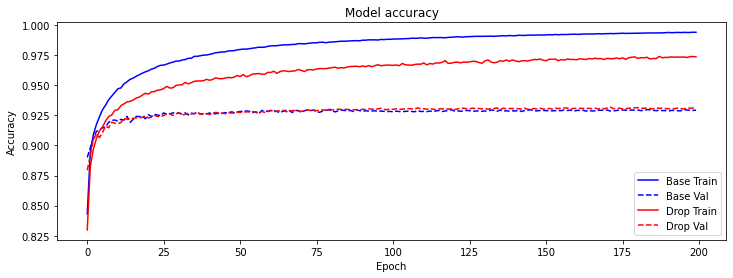

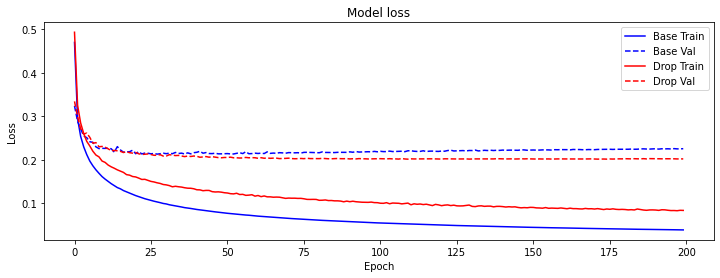

In [ ]:
#Test accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
_, drop_test_acc_1b = drop_model_1b.evaluate(test_batches, verbose = 0)
print('Dropout test accuracy: {}'.format(drop_test_acc_1b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(drop_history_1b.history['categorical_accuracy'],'r', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_categorical_accuracy'],'r--', label = 'Drop Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(drop_history_1b.history['loss'], 'r', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_loss'], 'r--', label = 'Drop Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the graphs, it is clear that dropout has significantly reduced overfitting and slightly improved test accuracy (from 92.07% we got 92.5%)


### Task 1.3 Build an input pipeline for data augmentation

*(weight ~5%)*

Build a data preprocessing pipeline to perform data augmentation. (You may use Keras ImageDataGenerator or write your own transformations.)

- Report the new classification accuracy. Make sure that you use the same number of training epochs as in Task 1.2.

- (Optional) Profile your input pipeline to identify the most time-consuming operation. What actions have you taken to address that slow operation? (*Hint: You may use the [TensorFlow Profiler](https://github.com/tensorflow/profiler).*)

####Add data augmentation

In order to train model with data augmentation, I will use ImageDataGenerator to transform training data randomly

In [ ]:
batch_size = 64

#construct aug train pipeline
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20, zoom_range=0.15,	horizontal_flip=True, fill_mode="nearest")
train_datagen.fit(x_train)
aug_train_batches = train_datagen.flow(x_train, y_train, shuffle = True, batch_size=batch_size)

Here is how newly augmented training images would look like:

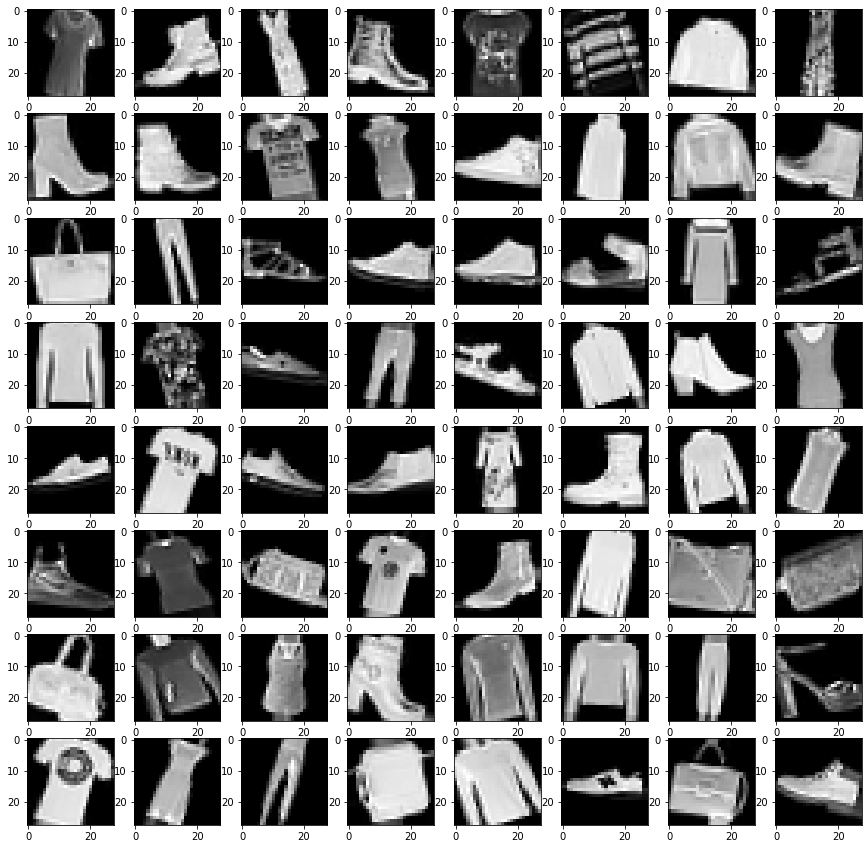

In [ ]:
#show augmented images
for x_batch, y_batch in aug_train_batches:
	# create a grid of 3x3 images
  plt.figure(figsize = (15,15))
  for i in range(0, 64):
    plt.subplot(8,8, 1 + i)
    plt.imshow(x_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
	# show the plot
  plt.show()
  break

Now I will train the ConvNet Baseline model with augmented data generated by ImageDataGenerator for 200 epochs

In [ ]:
# run model with augmented data
aug_model_1b = model_1b()
aug_history_1b = aug_model_1b.fit(
      aug_train_batches,
      steps_per_epoch=100,
      epochs=200,
      validation_data=valid_batches)

Epoch 1/200
100/100 [==============================] - 3s 25ms/step - loss: 0.9652 - categorical_accuracy: 0.6662 - val_loss: 0.6124 - val_categorical_accuracy: 0.7630
Epoch 2/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6653 - categorical_accuracy: 0.7475 - val_loss: 0.6130 - val_categorical_accuracy: 0.7751
Epoch 3/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6205 - categorical_accuracy: 0.7631 - val_loss: 0.6416 - val_categorical_accuracy: 0.7435
Epoch 4/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5773 - categorical_accuracy: 0.7852 - val_loss: 0.5593 - val_categorical_accuracy: 0.7864
Epoch 5/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5659 - categorical_accuracy: 0.7856 - val_loss: 0.5755 - val_categorical_accuracy: 0.7772
Epoch 6/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5490 - categorical_accuracy: 0.8009 - val_loss: 0.4811 - val_categorical_accuracy:

#####Comparison

Baseline test accuracy: 0.9207000136375427
Augmented test accuracy: 0.8901000022888184


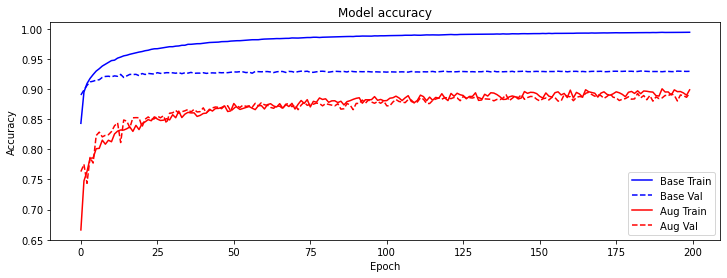

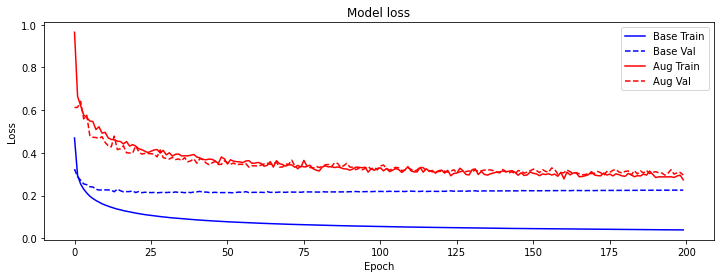

In [ ]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
_, aug_test_acc_1b = aug_model_1b.evaluate(test_batches, verbose = 0)
print("Augmented test accuracy: {}".format(aug_test_acc_1b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(aug_history_1b.history['categorical_accuracy'],'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_categorical_accuracy'],'r--', label = 'Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(aug_history_1b.history['loss'], 'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_loss'], 'r--', label = 'Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the graph, we can see that training with data augmentation has completely overcome overfitting; however, model optimization capacity has been reduced as we have lower accuracy and higher loss. The model also produces less accurate predictions on test set compared to the baseline model (89% accuracy on test set compared to 92%)

####Add dropout and augmented data

In this part, I will combine 2 regularization techniques which are dropout and augmentation together. Below are the results:

In [ ]:
# run model with both dropout layers and augmented data
drop_aug_model_1b = drop_model_1b()
drop_aug_history_1b = drop_aug_model_1b.fit(
      aug_train_batches,
      steps_per_epoch=100,
      epochs=200,
      validation_data=valid_batches)

Epoch 1/200
100/100 [==============================] - 3s 25ms/step - loss: 1.1222 - categorical_accuracy: 0.6275 - val_loss: 0.6183 - val_categorical_accuracy: 0.7641
Epoch 2/200
100/100 [==============================] - 2s 24ms/step - loss: 0.7344 - categorical_accuracy: 0.7264 - val_loss: 0.5512 - val_categorical_accuracy: 0.7903
Epoch 3/200
100/100 [==============================] - 2s 25ms/step - loss: 0.6417 - categorical_accuracy: 0.7534 - val_loss: 0.5298 - val_categorical_accuracy: 0.7993
Epoch 4/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6142 - categorical_accuracy: 0.7686 - val_loss: 0.5242 - val_categorical_accuracy: 0.8029
Epoch 5/200
100/100 [==============================] - 2s 24ms/step - loss: 0.6057 - categorical_accuracy: 0.7763 - val_loss: 0.5226 - val_categorical_accuracy: 0.7934
Epoch 6/200
100/100 [==============================] - 2s 24ms/step - loss: 0.5933 - categorical_accuracy: 0.7719 - val_loss: 0.4878 - val_categorical_accuracy:

#####Comparison

Baseline test accuracy: 0.9207000136375427
Dropout test accuracy: 0.9248999953269958
Augmented test accuracy: 0.8901000022888184
Dropout and augmentation test accuracy: 0.8844000101089478


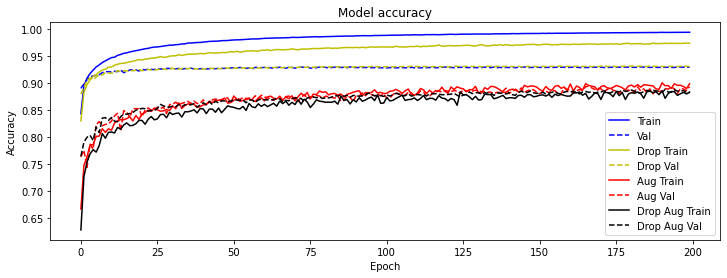

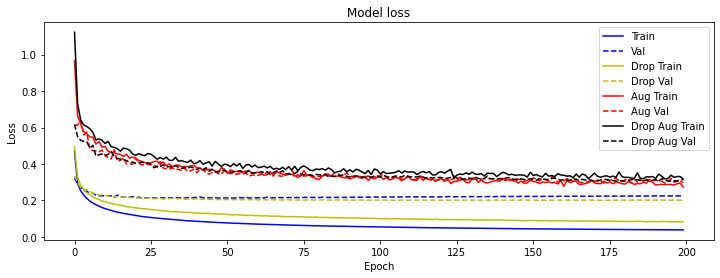

In [ ]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
print('Dropout test accuracy: {}'.format(drop_test_acc_1b))
print("Augmented test accuracy: {}".format(aug_test_acc_1b))
_, drop_aug_test_acc_1b = drop_aug_model.evaluate(test_batches, verbose = 0)
print('Dropout and augmentation test accuracy: {}'.format(drop_aug_test_acc_1b))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Val')
plt.plot(drop_history_1b.history['categorical_accuracy'],'y', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_categorical_accuracy'],'y--', label = 'Drop Val')
plt.plot(aug_history_1b.history['categorical_accuracy'],'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_categorical_accuracy'],'r--', label = 'Aug Val')
plt.plot(drop_aug_history_1b.history['categorical_accuracy'],'k', label = 'Drop Aug Train')
plt.plot(drop_aug_history_1b.history['val_categorical_accuracy'],'k--', label = 'Drop Aug Val')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Val')
plt.plot(drop_history_1b.history['loss'], 'y', label = 'Drop Train')
plt.plot(drop_history_1b.history['val_loss'], 'y--', label = 'Drop Val')
plt.plot(aug_history_1b.history['loss'], 'r', label = 'Aug Train')
plt.plot(aug_history_1b.history['val_loss'], 'r--', label = 'Aug Val')
plt.plot(drop_aug_history_1b.history['loss'], 'k', label = 'Drop Aug Train')
plt.plot(drop_aug_history_1b.history['val_loss'], 'k--', label = 'Drop Aug Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Looking at the graph, we can see that the combination of dropout and augmentation has the same effect into training process as augmentation only. This model also eliminates overfitting; however, it reduces training prediction and optimization capacity. Test accuracy is the lowest (88.4%) among 4 models so far. Next section we'll use transfer learning to see whether it improves model performace.

### Task 1.4 Fashion-MNIST with transfer learning

*(weight ~5%)*

Use a pretrained model as the convolutional base to improve the classification performance. (Hint: You may use models in Keras Applications or those in the TensorFlow Hub.)

- Try both with fine-tuning and without fine-tuning.
- Report the model performance as before.



####Reload dataset and construct pipelines toward pre-train model requirements

All pre-trained models available at Keras Applications require input images to have minimum size of 32x32 and exactly 3 channels (Keras, 2020). Since I will use VGG19 as the pretrained model for transfer learning in this section, I reload the dataset and pre-process the data to have size 150x150 and 3 channels then batch them to create data pipelines

In [ ]:
#load the dataset into train and test
train, test = tf.keras.datasets.fashion_mnist.load_data()
x, y = train
x_test, y_test = test

# Convert the training and test images into 3 channels
x = x.reshape(60000, 28*28, 1)
x_test = x_test.reshape(10000, 28*28, 1)
x = np.dstack([x] * 3)
x_test = np.dstack([x_test]*3)

#reshape and normalize
x = x.reshape(60000, 28, 28, 3).astype('float32')/255
y = to_categorical(y)
x_test = x_test.reshape(10000, 28, 28, 3).astype('float32')/255
y_test = to_categorical(y_test)

#split train, validation sets
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2)

#construct pipelines
train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train))
valid_set = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# function to resize images into size 150x150
def pre_process_image(image, label):
  image = tf.image.resize(image, (150, 150))
  return image, label

# batch the sets according to batch_size
batch_size = 64
train_batches = train_set.map(pre_process_image).shuffle(buffer_size=1024).batch(batch_size).cache().repeat()
valid_batches = valid_set.map(pre_process_image).batch(batch_size).cache().repeat()
test_batches = test_set.map(pre_process_image).batch(batch_size)

# check the image size in batch data
xtrain_batch, ytrain_batch = next(iter(train_batches))
xvalid_batch, yvalid_batch = next(iter(valid_batches))
xtest_batch, ytest_batch = next(iter(test_batches))

print("xtrain_batch_size:", xtrain_batch.shape[1:])
print("xvalid_batch_size:", xvalid_batch.shape[1:])
print("xtest_batch_size:", xtest_batch.shape[1:])

xtrain_batch_size: (150, 150, 3)
xvalid_batch_size: (150, 150, 3)
xtest_batch_size: (150, 150, 3)


####Fixed Pre-trained Conv-base model

As mentioned earlier, I would choose VGG19 as the pretrained model for transfer learning:

In [ ]:
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  classes = 10)
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#####An experiment with the number of nodes

In this section, similar to the above-conducted experiment, I will tried out different numbers of nodes to determine the best number of nodes in the Dense layer of our modified model. In the convolutional base, I set the weights not to be trainable, meaning that during training, these weight in the convolutional base will not be updated.

In [ ]:
def pretrn_model(dense):
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(dense, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)
  loss = keras.losses.CategoricalCrossentropy(from_logits=False)
  metrics = keras.metrics.CategoricalAccuracy()
  
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
#try out 3 different numbers of dense nodes
denses = [256, 512, 1024]
results = []

for dense in denses:
  conv_base.trainable = False
  model = pretrn_model(dense)
  history = model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=20,
      validation_data=valid_batches,
      validation_steps=10,
      verbose = 0)
  test_loss, test_acc = model.evaluate(test_batches, verbose = 0)
  print('Dense: {}, test accuracy: {}'.format(dense, test_acc))
  results.append(test_acc)

# Parameter values at which test acc is highest
acc_best = np.argmax(results)
best_dense = denses[acc_best]
print("Best model with dense layer = {}, Test accuracy for 20 epochs: {}".format(best_dense, results[acc_best]))

Dense: 256, test accuracy: 0.8776999711990356
Dense: 512, test accuracy: 0.8751000165939331
Dense: 1024, test accuracy: 0.8752999901771545
Best model with dense layer = 256, Test accuracy for 20 epochs: 0.8776999711990356


Results after training each model for 20 epochs show that a Dense layer of 256 nodes produces higher test accuracy than the other 2 options. Test accuracy produced by three models are:

- Dense: 256, test accuracy: 0.8776999711990356

- Dense: 512, test accuracy: 0.8751000165939331

- Dense: 1024, test accuracy: 0.8752999901771545

I will choose 256 as the number of nodes for my modified model below.


#####Fixed Pre-trained Conv-base model architecture

Below is how our model with fixed pretrained conv base and a dense layer of 256 nodes will look like. I will train this model for 200 epochs then compare it with our baseline model above:

In [ ]:
def pretrn_model():
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)
  loss = keras.losses.CategoricalCrossentropy(from_logits=False)
  metrics = keras.metrics.CategoricalAccuracy()
  
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

conv_base.trainable = False
pretrn_model = pretrn_model()
pretrn_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                2570      
Total params: 22,124,362
Trainable params: 2,099,978
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
pretrn_history = pretrn_model.fit(
      train_batches,
      steps_per_epoch=100,
      epochs=200,
      validation_data=valid_batches,
      validation_steps=10)

Epoch 1/200
100/100 [==============================] - 10s 99ms/step - loss: 1.0975 - categorical_accuracy: 0.6342 - val_loss: 0.5684 - val_categorical_accuracy: 0.7688
Epoch 2/200
100/100 [==============================] - 10s 97ms/step - loss: 0.5462 - categorical_accuracy: 0.7989 - val_loss: 0.4484 - val_categorical_accuracy: 0.8344
Epoch 3/200
100/100 [==============================] - 10s 97ms/step - loss: 0.4713 - categorical_accuracy: 0.8206 - val_loss: 0.3768 - val_categorical_accuracy: 0.8562
Epoch 4/200
100/100 [==============================] - 10s 97ms/step - loss: 0.4167 - categorical_accuracy: 0.8530 - val_loss: 0.3381 - val_categorical_accuracy: 0.8828
Epoch 5/200
100/100 [==============================] - 10s 97ms/step - loss: 0.4134 - categorical_accuracy: 0.8495 - val_loss: 0.3269 - val_categorical_accuracy: 0.8844
Epoch 6/200
100/100 [==============================] - 10s 97ms/step - loss: 0.3903 - categorical_accuracy: 0.8577 - val_loss: 0.3249 - val_categorical_acc

#####Comparison

Baseline test accuracy: 0.9207000136375427
Pre-train with fixed conv base test accuracy: 0.910937488079071


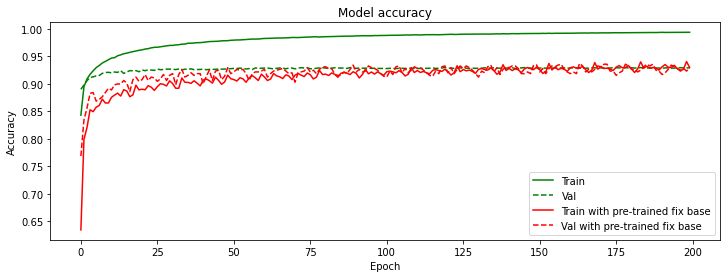

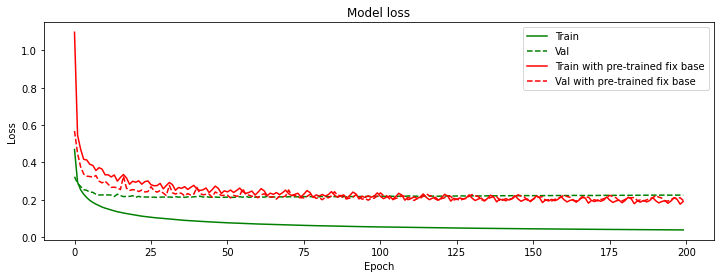

In [ ]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
pretrn_test_loss, pretrn_test_acc = pretrn_model.evaluate(test_batches, verbose = 0)
print("Pre-train with fixed conv base test accuracy: {}".format(pretrn_test_acc))

# Plot training accuracy values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'g', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'g--', label = 'Base Val')
plt.plot(pretrn_history.history['categorical_accuracy'],'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_categorical_accuracy'],'r--', label = 'Fixed Conv Base Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'g', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'g--', label = 'Base Val')
plt.plot(pretrn_history.history['loss'], 'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_loss'], 'r--', label = 'Fixed Conv Base Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

The Fixed Pre-trained Conv-base model is obviously more robust and efficient than our baseline model. Although test accuracy is slightly lower (91.09% compared to 92.07%), its optimization and especially generalization capacity are both more impactful since there is no sign of overfitting.

####Fine-tuned model

Now, I am going to fine tune the pretrained model by setting the last block in VGG19 conv base into trainable. This means that during training the weights in the last block of the convolutional base will be updated. Then I will run the model for 200 epochs and compare the results:

In [ ]:
# reload pretrained model and define tuning model
conv_base = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3),
                  classes = 10)

def tuning_model():
  model = models.Sequential()
  model.add(conv_base)
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu', kernel_initializer=initializers.he_uniform(seed=0)))
  model.add(layers.Dense(10, activation='softmax'))
  
  optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=1e-03, nesterov=True)
  loss = keras.losses.CategoricalCrossentropy(from_logits=False)
  metrics = keras.metrics.CategoricalAccuracy()
  
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model
  
# run the pretrained model with last layer trainable and one dense layer on top
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

tuning_model = tuning_model(best_dense)
tuning_model.summary()

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_93 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_202 (Dense)            (None, 256)               2097408   
_________________________________________________________________
dense_203 (Dense)            (None, 10)                2570      
Total params: 22,124,362
Trainable params: 11,539,210
Non-trainable params: 10,585,152
_________________________________________________________________


In [ ]:
tuning_history = tuning_model.fit(
       train_batches,
       steps_per_epoch=100,
       epochs=200,
       validation_data=valid_batches,
       validation_steps=10)

Epoch 1/200
100/100 [==============================] - 11s 114ms/step - loss: 0.8726 - categorical_accuracy: 0.6948 - val_loss: 0.3502 - val_categorical_accuracy: 0.8562
Epoch 2/200
100/100 [==============================] - 11s 112ms/step - loss: 0.3895 - categorical_accuracy: 0.8572 - val_loss: 0.3101 - val_categorical_accuracy: 0.8813
Epoch 3/200
100/100 [==============================] - 11s 112ms/step - loss: 0.3218 - categorical_accuracy: 0.8791 - val_loss: 0.2490 - val_categorical_accuracy: 0.9062
Epoch 4/200
100/100 [==============================] - 11s 112ms/step - loss: 0.2793 - categorical_accuracy: 0.8997 - val_loss: 0.2246 - val_categorical_accuracy: 0.9203
Epoch 5/200
100/100 [==============================] - 11s 112ms/step - loss: 0.2745 - categorical_accuracy: 0.8980 - val_loss: 0.2184 - val_categorical_accuracy: 0.9141
Epoch 6/200
100/100 [==============================] - 11s 112ms/step - loss: 0.2552 - categorical_accuracy: 0.9080 - val_loss: 0.2255 - val_categoric

#####Comparison

Baseline test accuracy: 0.9207000136375427
Pre-train with fixed conv base test accuracy: 0.910937488079071
Fine tuning test accuracy: 0.9125000238418579


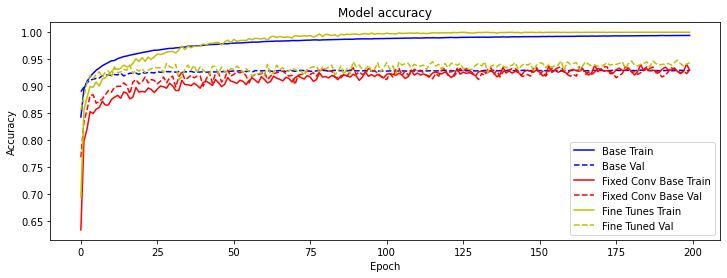

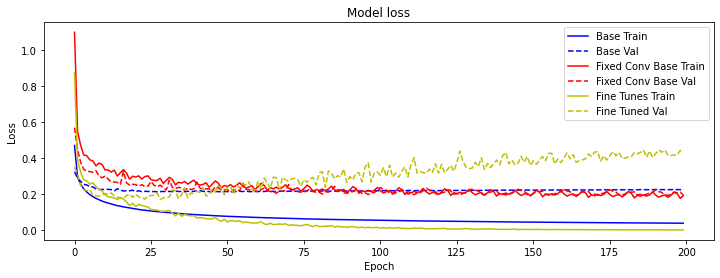

In [ ]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
print("Pre-train with fixed conv base test accuracy: {}".format(pretrn_test_acc))
tuning_test_loss, tuning_test_acc = tuning_model.evaluate(test_batches, verbose = 0)
print("Fine tuning test accuracy: {}".format(tuning_test_acc))

# Compare fix conv base vs fine tuning
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(pretrn_history.history['categorical_accuracy'],'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_categorical_accuracy'],'r--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['categorical_accuracy'],'y', label = 'Fine Tunes Train')
plt.plot(tuning_history.history['val_categorical_accuracy'],'y--', label = 'Fine Tuned Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,4))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(pretrn_history.history['loss'], 'r', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_loss'], 'r--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['loss'], 'y', label = 'Fine Tunes Train')
plt.plot(tuning_history.history['val_loss'], 'y--', label = 'Fine Tuned Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

According to the graphs, we can see that although its training and validation accuracy trends are both increasing, the fine tuned training gets overfitted in terms of loss values after around 15 epochs. Hence, between pretrained models with and without fine tuning, the latter one is more advisable in this case.

### Task 1.5 Performance comparison

*(weight ~2%)*

Record the test accuracy achieved at different training configurations above. Which method achieved the highest accuracy? Why did it work better for this problem?


Now in this part, I will compare all the models we have experimented so far on Fashion MNIST dataset.

Baseline test accuracy: 0.9207000136375427
Dropout test accuracy: 0.9248999953269958
Augmentation test accuracy: 0.8901000022888184
Dropout + Augmentation test accuracy: 0.8844000101089478
Pre-train with fixed conv base test accuracy: 0.910937488079071
Fine tuning test accuracy: 0.9125000238418579


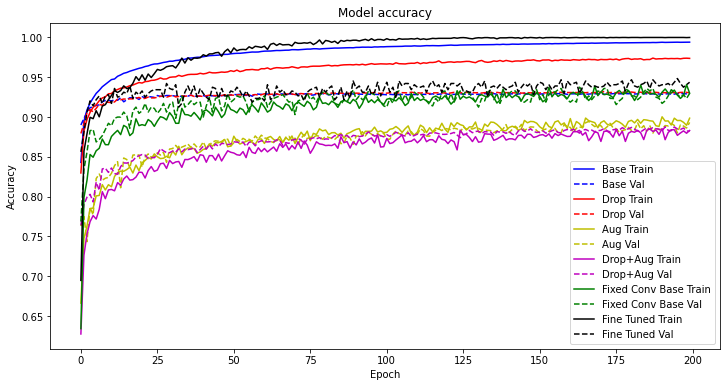

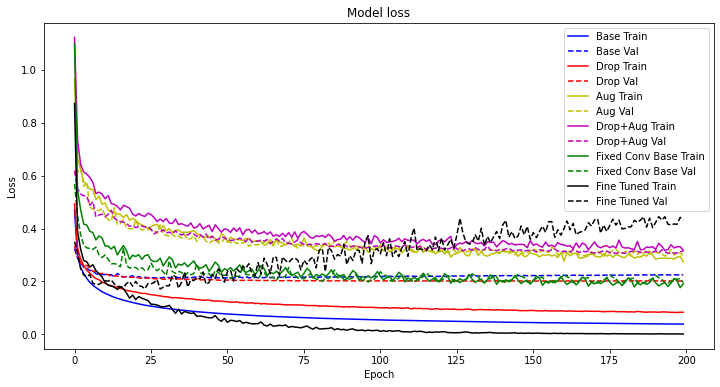

In [ ]:
# Test set accuracy
print("Baseline test accuracy: {}".format(best_test_acc_1b))
print("Dropout test accuracy: {}".format(drop_test_acc))
print("Augmentation test accuracy: {}".format(aug_test_acc))
print("Dropout + Augmentation test accuracy: {}".format(drop_aug_test_acc))
print("Pre-train with fixed conv base test accuracy: {}".format(pretrn_test_acc))
print("Fine tuning test accuracy: {}".format(tuning_test_acc))

# Compare fix conv base vs fine tuning
plt.figure(figsize = (12,6))
plt.plot(best_history_1b.history['categorical_accuracy'],'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_categorical_accuracy'],'b--', label = 'Base Val')
plt.plot(drop_history.history['categorical_accuracy'],'r', label = 'Drop Train')
plt.plot(drop_history.history['val_categorical_accuracy'],'r--', label = 'Drop Val')
plt.plot(aug_history.history['categorical_accuracy'],'y', label = 'Aug Train')
plt.plot(aug_history.history['val_categorical_accuracy'],'y--', label = 'Aug Val')
plt.plot(drop_aug_history.history['categorical_accuracy'],'m', label = 'Drop+Aug Train')
plt.plot(drop_aug_history.history['val_categorical_accuracy'],'m--', label = 'Drop+Aug Val')
plt.plot(pretrn_history.history['categorical_accuracy'],'g', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_categorical_accuracy'],'g--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['categorical_accuracy'],'k', label = 'Fine Tuned Train')
plt.plot(tuning_history.history['val_categorical_accuracy'],'k--', label = 'Fine Tuned Val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training loss values
plt.figure(figsize = (12,6))
plt.plot(best_history_1b.history['loss'], 'b', label = 'Base Train')
plt.plot(best_history_1b.history['val_loss'], 'b--', label = 'Base Val')
plt.plot(drop_history.history['loss'], 'r', label = 'Drop Train')
plt.plot(drop_history.history['val_loss'], 'r--', label = 'Drop Val')
plt.plot(aug_history.history['loss'], 'y', label = 'Aug Train')
plt.plot(aug_history.history['val_loss'], 'y--', label = 'Aug Val')
plt.plot(drop_aug_history.history['loss'], 'm', label = 'Drop+Aug Train')
plt.plot(drop_aug_history.history['val_loss'], 'm--', label = 'Drop+Aug Val')
plt.plot(pretrn_history.history['loss'], 'g', label = 'Fixed Conv Base Train')
plt.plot(pretrn_history.history['val_loss'], 'g--', label = 'Fixed Conv Base Val')
plt.plot(tuning_history.history['loss'], 'k', label = 'Fine Tuned Train')
plt.plot(tuning_history.history['val_loss'], 'k--', label = 'Fine Tuned Val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Better accuracy with Learning rate: 0.01, Momentum: 0.9, Decay: 2e-06, test accuracy: 0.8913999795913696
Worse accuracy with Learning rate: 0.01, Momentum: 0.9, Decay: 0.001, test accuracy: 0.8855999708175659


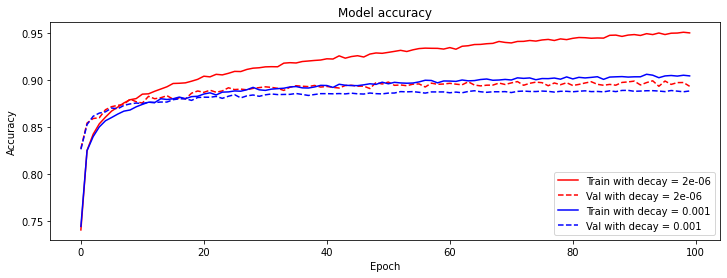

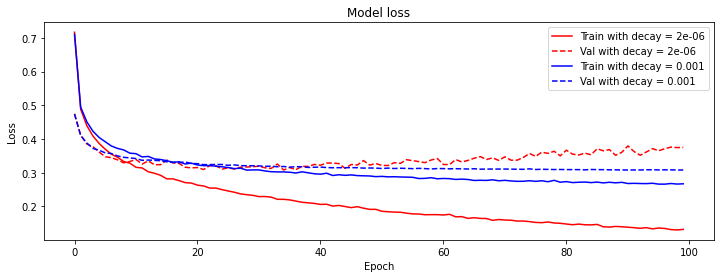

In [ ]:
#results of DNN models from previous section

Conclusion:

- As can be seen in the graphs, Convolutional Net models are proved to be more effective and powerful in terms of training performance than Densely Connected Net models

- Among the ConvNet models, the best model would be model with fixed pretrained convolutinal base. Although the test accuracy produced by this model is the third highest among experimented models, it's the most robust model so far with fair optimization and generalization capacity.

- The reason why fixed pretrained convolutional base model works better for this image classification problem is that the VGG19 base was trained on a very large dataset which is the ImageNet dataset (Liu at el, 2015), its set of weights is more powerful since it has been optimized over a wide variety of training images. This pre-trained set of weights then is used for features extraction in our dataset. The features extracted from this convolutional base are efficient so we only need one more Dense layer on top for our model to be specified on our dataset. 

---
##**REFERENCE**

Brownie, J 2019, How to Develop VGG, Inception and ResNet Modules from Scratch in Keras, <https://machinelearningmastery.com/how-to-implement-major-architecture-innovations-for-convolutional-neural-networks/>.

He, K, Zhang, X, Ren, S & Sun, J 2016, 'Deep Residual Learning for Image Recognition', in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), pp. 770-8.

Keras 2020, Keras Applications, <https://keras.io/api/applications/>.

Liu, S & Deng, W 2015, 'Very deep convolutional neural network based image classification using small training sample size', in 2015 3rd IAPR Asian Conference on Pattern Recognition (ACPR), pp. 730-4.


---
**END OF ASSIGNMENT TWO**